In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset

# from verl.utils.reward_score.swe_smith_oracle import extract_minimal_patch, extract_diff, score_patching
import cydifflib
from huggingface_hub import snapshot_download

In [10]:
import re

DIFF_PATTERN = re.compile(r"^diff(?:.*)")
PATCH_PATTERN = re.compile(
    r"(?:diff[\w\_\.\ \/\-]+\n)?\-\-\-\s+a\/(?:.*?)\n\+\+\+\s+b\/(?:.*?)(?=diff\ |\-\-\-\ a\/|\Z)",
    re.DOTALL,
)
PATCH_FILE_PATTERN = re.compile(r"\-\-\-\s+a\/(?:.+)\n\+\+\+\s+b\/(?:.+)")
PATCH_HUNK_PATTERN = re.compile(
    r"\@\@\s+\-(\d+),(\d+)\s+\+(\d+),(\d+)\s+\@\@(.+?)(?=diff\ |\-\-\-\ a\/|\@\@\ \-|\Z)",
    re.DOTALL,
)

# from swe-bench
def get_first_idx(charlist):
    first_min = charlist.index("-") if "-" in charlist else len(charlist)
    first_plus = charlist.index("+") if "+" in charlist else len(charlist)
    return min(first_min, first_plus)

def get_last_idx(charlist):
    char_idx = get_first_idx(charlist[::-1])
    last_idx = len(charlist) - char_idx
    return last_idx + 1

def strip_content(hunk):
    first_chars = list(map(lambda x: None if not len(x) else x[0], hunk.split("\n")))
    first_idx = get_first_idx(first_chars)
    last_idx = get_last_idx(first_chars)
    new_lines = list(map(lambda x: x.rstrip(), hunk.split("\n")[first_idx:last_idx]))
    new_hunk = "\n" + "\n".join(new_lines) + "\n"
    return new_hunk, first_idx - 1

def get_hunk_stats(pre_start, pre_len, post_start, post_len, hunk, total_delta):
    stats = {"context": 0, "added": 0, "subtracted": 0}
    hunk = hunk.split("\n", 1)[-1].strip("\n")
    for line in hunk.split("\n"):
        if line.startswith("-"):
            stats["subtracted"] += 1
        elif line.startswith("+"):
            stats["added"] += 1
        else:
            stats["context"] += 1
    context = stats["context"]
    added = stats["added"]
    subtracted = stats["subtracted"]
    pre_len = context + subtracted
    post_start = pre_start + total_delta
    post_len = context + added
    total_delta = total_delta + (post_len - pre_len)
    return pre_start, pre_len, post_start, post_len, total_delta

def extract_diff(response):
    """
    Extracts the diff from a response formatted in different ways
    """
    if response is None:
        return None
    diff_matches = []
    other_matches = []
    pattern = re.compile(r"\<([\w-]+)\>(.*?)\<\/\1\>", re.DOTALL)
    for code, match in pattern.findall(response):
        if code in {"diff", "patch"}:
            diff_matches.append(match)
        else:
            other_matches.append(match)
    pattern = re.compile(r"```(\w+)?\n(.*?)```", re.DOTALL)
    for code, match in pattern.findall(response):
        if code in {"diff", "patch"}:
            diff_matches.append(match)
        else:
            other_matches.append(match)
    if diff_matches:
        return diff_matches[0]
    if other_matches:
        return other_matches[0]
    return response.split("</s>")[0]

def extract_minimal_patch(model_patch):
    model_patch = model_patch.lstrip("\n")
    new_patch = ""
    for patch in PATCH_PATTERN.findall(model_patch):
        total_delta = 0
        diff_header = DIFF_PATTERN.findall(patch)
        patch_header = PATCH_FILE_PATTERN.findall(patch)[0]
        if patch_header:
            new_patch += patch_header + "\n"
        for hunk in PATCH_HUNK_PATTERN.findall(patch):
            pre_start, pre_len, post_start, post_len, content = hunk
            pre_start, pre_len, post_start, post_len, content = list(
                map(lambda x: int(x) if x.isnumeric() else x, hunk)
            )
            content, adjust_pre_start = strip_content(content)
            pre_start += adjust_pre_start
            pre_start, pre_len, post_start, post_len, total_delta = get_hunk_stats(
                pre_start, pre_len, post_start, post_len, content, total_delta
            )
            new_patch += (
                f"@@ -{pre_start},{pre_len} +{post_start},{post_len} @@{content}"
            )
    return new_patch

In [27]:
# ds = load_dataset("rasdani/SWE-smith-oracle-4k-context-1k-diff", split="train")
ds = load_dataset("rasdani/github-patches-genesys-2k-context-1k-diff", split="train")
ds

Dataset({
    features: ['problem_id', 'source', 'task_type', 'in_source_id', 'prompt', 'golden_diff', 'verification_info', 'num_tokens', 'num_tokens_diff'],
    num_rows: 8576
})

In [28]:
patch_map = {}

for example in ds:
    patch_map[example["prompt"].strip()] = example["golden_diff"].strip()

In [ ]:
snapshot_download(
    # repo_id="rasdani/deepseek_r1_qwen3_8b_swe_smith_oracle_4k-rollouts", 
    repo_id="rasdani/deepseek_r1_7b_gh_patches_2k_fixed_reward-rollouts", 
    # local_dir="/home/daniel/git/verl/rollouts/deepseek_r1_qwen3_8b_swe_smith_oracle_4k",
    local_dir="/home/daniel/git/verl/rollouts/deepseek_r1_7b_gh_patches_2k_fixed_reward",
    repo_type="dataset"
)

In [30]:
# train_rollout_dir = "~/persistent/rollouts/deepseek_r1_7b_gh_patches_2k_fixed_reward/train"
# train_rollout_dir = "rollouts/deepseek_r1_qwen3_8b_swe_smith_oracle_4k/train"
rollout_path = "rollouts/deepseek_r1_7b_gh_patches_2k_fixed_reward/train/175.jsonl"
# rollout_path = "rollouts/deepseek_r1_qwen3_8b_swe_smith_oracle_4k/train/39.jsonl"
df = pd.read_json(rollout_path, lines=True)
df.head()

,input,output,score,step
0,<｜User｜>We are currently solving the following...,"Okay, so I've got this issue where the bokeh.p...",0.432537,175
1,<｜User｜>We are currently solving the following...,"Okay, let's tackle this bug. The issue is that...",0.456973,175
2,<｜User｜>We are currently solving the following...,"Okay, I need to figure out what's wrong with t...",0.615110,175
3,<｜User｜>We are currently solving the following...,"Okay, I need to figure out which part of the p...",0.531322,175
4,<｜User｜>We are currently solving the following...,"Alright, I need to figure out what the bug is ...",0.414815,175


In [31]:
df["input"] = df.apply(lambda x: x["input"].lstrip("<｜User｜>").rstrip("<｜Assistant｜>").strip(), axis=1)
df["input"] = df.apply(lambda x: x["input"].rstrip("<｜Assistant｜><think>").strip(), axis=1)
df.head()

,input,output,score,step
0,We are currently solving the following issue w...,"Okay, so I've got this issue where the bokeh.p...",0.432537,175
1,We are currently solving the following issue w...,"Okay, let's tackle this bug. The issue is that...",0.456973,175
2,We are currently solving the following issue w...,"Okay, I need to figure out what's wrong with t...",0.615110,175
3,We are currently solving the following issue w...,"Okay, I need to figure out which part of the p...",0.531322,175
4,We are currently solving the following issue w...,"Alright, I need to figure out what the bug is ...",0.414815,175


In [33]:
idx = 0
print("Score:")
print(df["score"][idx])
print("Input:")
print(df["input"][idx])
print("Output:")
print(df["output"][idx])
think_splits = df["output"][idx].split("</think>")
after_think = think_splits[1].strip() if len(think_splits) == 2 else ""
# print("After think:")
# print(after_think)
extracted_diff = extract_diff(after_think)
print("Extracted diff:")
print(extracted_diff)
minimal_model_patch = extract_minimal_patch(extracted_diff)
print("Golden diff:")
golden_diff = patch_map[df["input"][idx]]
print(golden_diff)
print("Minimal model patch:")
print(minimal_model_patch)
minimal_golden_patch = extract_minimal_patch(golden_diff)
print("Minimal Golden patch:")
print(minimal_golden_patch)

# print(minimal_golden_patch == minimal_model_patch)
# unidiff = difflib.unified_diff(extract_minimal_patch(patch_map[df["input"][idx]]), extract_minimal_patch(extract_diff(df["output"][idx])))
# joined = "\n".join(unidiff)
# print(joined)

Score:
0.43253710865974404
Input:
We are currently solving the following issue within our repository. Here is the issue text:
--- BEGIN ISSUE ---
bokeh.palettes refguide page header mis-renders
Add lots of space, changes font size, for some reason (just this page)

https://docs.bokeh.org/en/latest/docs/reference/palettes.html


--- END ISSUE ---

Below are some code segments, each from a relevant file. One or more of these files may contain bugs.
--- BEGIN FILES ---
Path: `bokeh/sphinxext/bokeh_palette_group.py`
Content:
```
1 #-----------------------------------------------------------------------------
2 # Copyright (c) 2012 - 2019, Anaconda, Inc., and Bokeh Contributors.
3 # All rights reserved.
4 #
5 # The full license is in the file LICENSE.txt, distributed with this software.
6 #-----------------------------------------------------------------------------
7 ''' Generate visual representations of palettes in Bokeh palette groups.
8 
9 The ``bokeh.palettes`` modules expose attribut

In [34]:
from unidiff import PatchSet

ps = PatchSet(minimal_model_patch)
for patch in ps:
    print(patch.source_file)
    print(patch.target_file)
    for hunk in patch:
        print(hunk)

a/mido/messages/checks.py
b/mido/messages/checks.py
@@ -34,3 +34,3 @@
-        elif not MIN_SONGPOS < pos <= MAX_SONGPOS:
-            raise ValueError('song pos must be in range {}..{}'.format(
-                          MIN_SONGPOS, MAX_SONGPOS + 1))
+        elif not MIN_SONGPOS <= pos <= MAX_SONGPOS:
+            raise ValueError('song pos must be in range {}..{}'.format(
+                         MIN_SONGPOS, MAX_SONGPOS))


@@ -55,2 +55,2 @@
-        elif not 0 < value <= 7:
+        elif not 0 <= value <= 7:
             raise ValueError('frame_type must be in range 0..7')

@@ -62,2 +62,2 @@
-        elif not 0 < value < 15:
+        elif not 0 <= value <= 15:
             raise ValueError('frame_value must be in range 0..15')



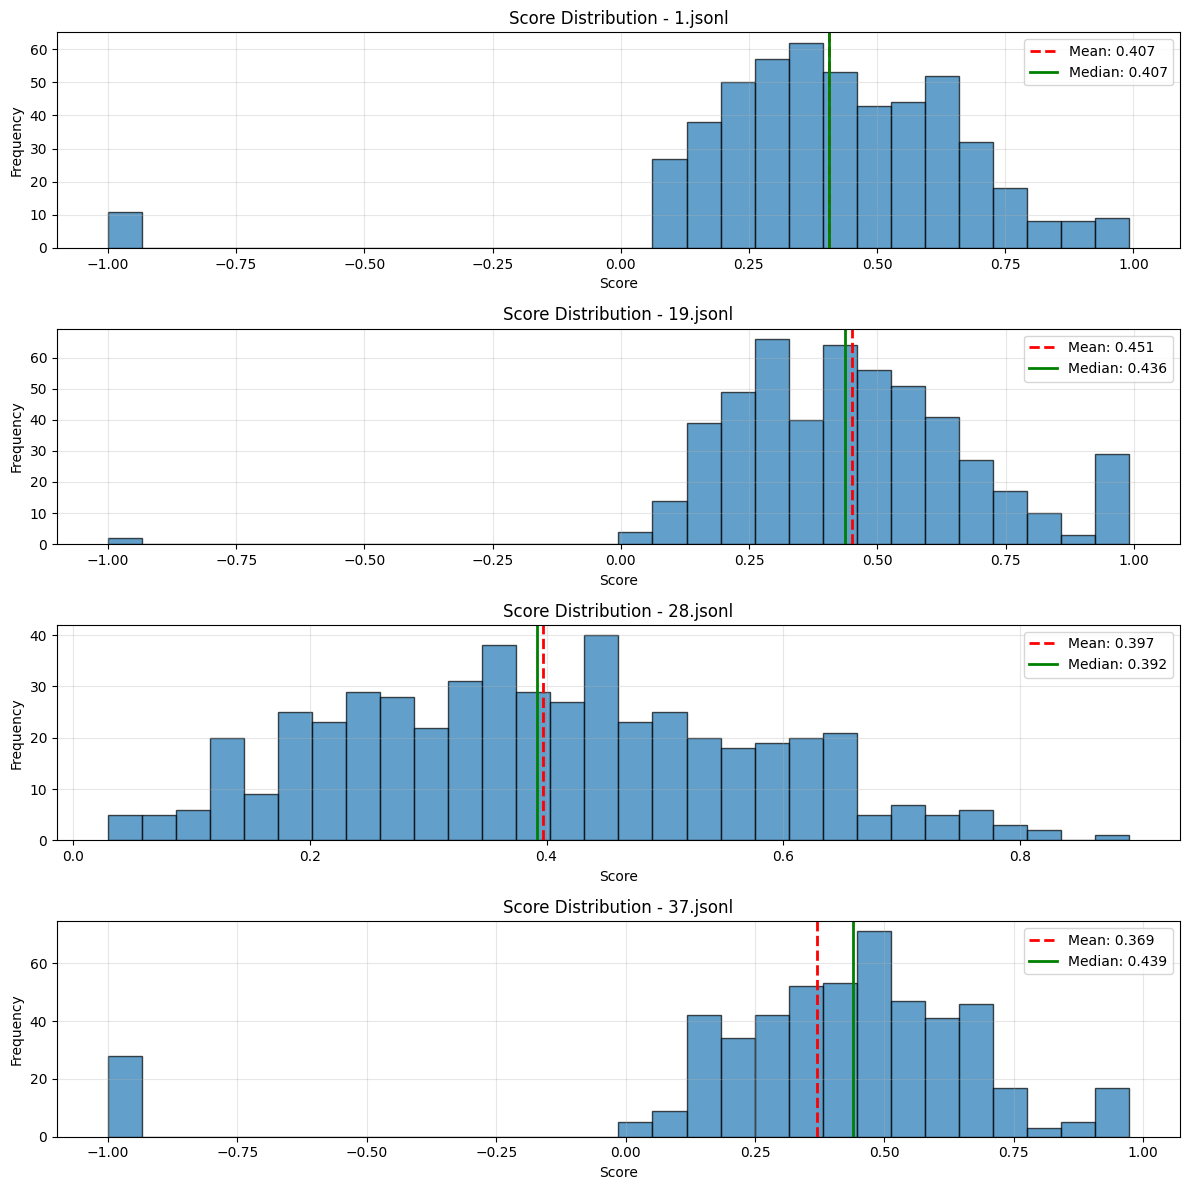

Plotted 4 files:
  1.jsonl
  19.jsonl
  28.jsonl
  37.jsonl


In [4]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# Get all JSONL files in the directory
jsonl_files = sorted(glob.glob(os.path.join(os.path.expanduser(train_rollout_dir), "*.jsonl")))

# Filter to every 10th file
every_10th_files = jsonl_files[::10]

# Create subplots
fig, axes = plt.subplots(len(every_10th_files), 1, figsize=(12, 3*len(every_10th_files)))
if len(every_10th_files) == 1:
    axes = [axes]

# Plot histogram for each file
for i, file_path in enumerate(every_10th_files):
    # Read the JSONL file
    df = pd.read_json(file_path, lines=True)
    
    # Calculate mean and median
    mean_score = df['score'].mean()
    median_score = df['score'].median()
    
    # Create histogram
    axes[i].hist(df['score'], bins=30, alpha=0.7, edgecolor='black')
    
    # Add vertical lines for mean and median
    axes[i].axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.3f}')
    axes[i].axvline(median_score, color='green', linestyle='-', linewidth=2, label=f'Median: {median_score:.3f}')
    
    axes[i].set_title(f'Score Distribution - {os.path.basename(file_path)}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the files being plotted
print(f"Plotted {len(every_10th_files)} files:")
for file_path in every_10th_files:
    print(f"  {os.path.basename(file_path)}")


In [ ]:
# Count perfect scores (score = 1.0) in each JSONL file
print("Perfect scores (score = 1.0) per JSONL file:")
print("=" * 50)

for file_path in jsonl_files:
    df = pd.read_json(file_path, lines=True)
    perfect_scores = (df['score'] == 1.0).sum()
    total_samples = len(df)
    percentage = (perfect_scores / total_samples) * 100 if total_samples > 0 else 0
    
    print(f"{os.path.basename(file_path)}:")
    print(f"  Perfect scores: {perfect_scores}/{total_samples} ({percentage:.2f}%)")
    print()

# Summary statistics
print("Summary:")
print("=" * 20)
all_perfect_scores = []
all_total_samples = []

for file_path in jsonl_files:
    df = pd.read_json(file_path, lines=True)
    perfect_scores = (df['score'] == 1.0).sum()
    total_samples = len(df)
    all_perfect_scores.append(perfect_scores)
    all_total_samples.append(total_samples)

total_perfect = sum(all_perfect_scores)
total_samples = sum(all_total_samples)
overall_percentage = (total_perfect / total_samples) * 100 if total_samples > 0 else 0

print(f"Total perfect scores across all files: {total_perfect}/{total_samples} ({overall_percentage:.2f}%)")
print(f"Average perfect scores per file: {np.mean(all_perfect_scores):.2f}")
print(f"Min perfect scores in a file: {min(all_perfect_scores)}")
print(f"Max perfect scores in a file: {max(all_perfect_scores)}")


In [ ]:
# Create a dataframe with all rollouts that have perfect scores (score = 1.0)
perfect_rollouts = []

for file_path in jsonl_files:
    df = pd.read_json(file_path, lines=True)
    # Filter for perfect scores
    perfect_df = df[df['score'] == 1.0].copy()
    # Add source file information
    perfect_df['source_file'] = os.path.basename(file_path)
    perfect_rollouts.append(perfect_df)

# Combine all perfect rollouts into one dataframe
if perfect_rollouts:
    all_perfect_rollouts = pd.concat(perfect_rollouts, ignore_index=True)
    print(f"Found {len(all_perfect_rollouts)} rollouts with perfect scores")
    print(f"Shape of perfect rollouts dataframe: {all_perfect_rollouts.shape}")
    print("\nFirst few perfect rollouts:")
    print(all_perfect_rollouts.head())
else:
    print("No perfect rollouts found")
    all_perfect_rollouts = pd.DataFrame()


In [ ]:
print(all_perfect_rollouts["output"][30])